# AI影像辨識 第2課 -- OpenCV 人臉辨識    
OpenCV Cascade Classifier doc:  
https://docs.opencv.org/4.x/db/d28/tutorial_cascade_classifier.html  
Haar模型 權重檔:  
https://github.com/opencv/opencv/tree/master/data/haarcascades

人臉辨識分又可再分為兩類工作:
1.   找到人臉: 找出一張影像上人臉的位置並取得臉的特徵點，  
     又可再達成計算人數、 表情辨認等工作
2.   找出是哪張人臉: 利用臉的特徵點進一步分辨或分類出是誰的臉

OpenCV官方文件上對於Haar Cascades演算法的說明圖:  
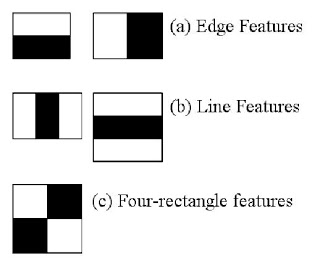
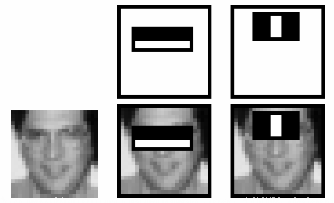

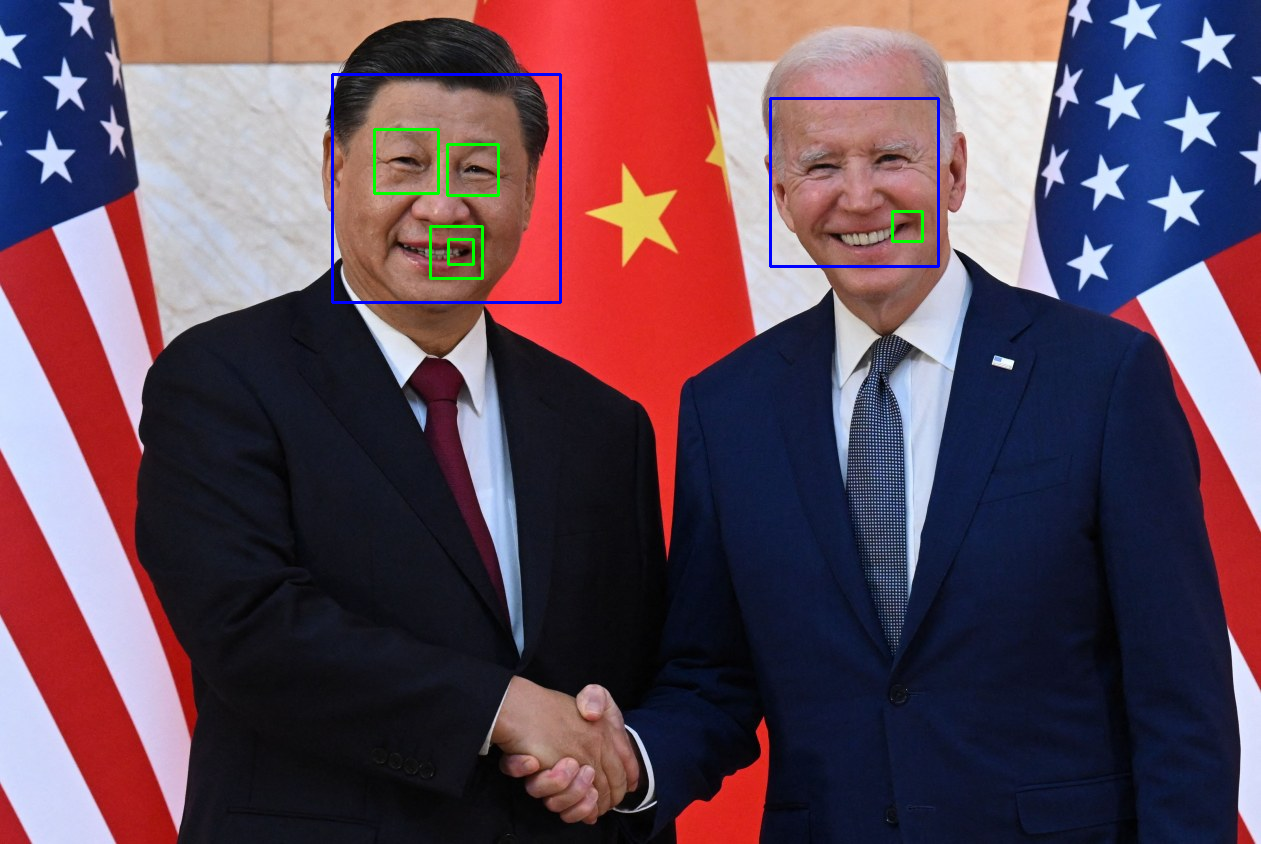

In [1]:
# 第一部分之1 -- 找到人臉
# 匯入 OpenCV 與其他必要模組
import cv2
from google.colab.patches import cv2_imshow

# Load the Haar cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

#標記臉與眼睛位置的函數
def detect_faces(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

    return img

#上傳測試影像後，自行修改檔名使用
img = cv2.imread("a.jpg")
cv2_imshow(detect_faces(img))



# Example usage with a webcam (if available)
# 以下於本地執行時，有攝影機時可使用
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    detected_faces = detect_faces(frame)
    cv2.imshow('Face Detection', detected_faces)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



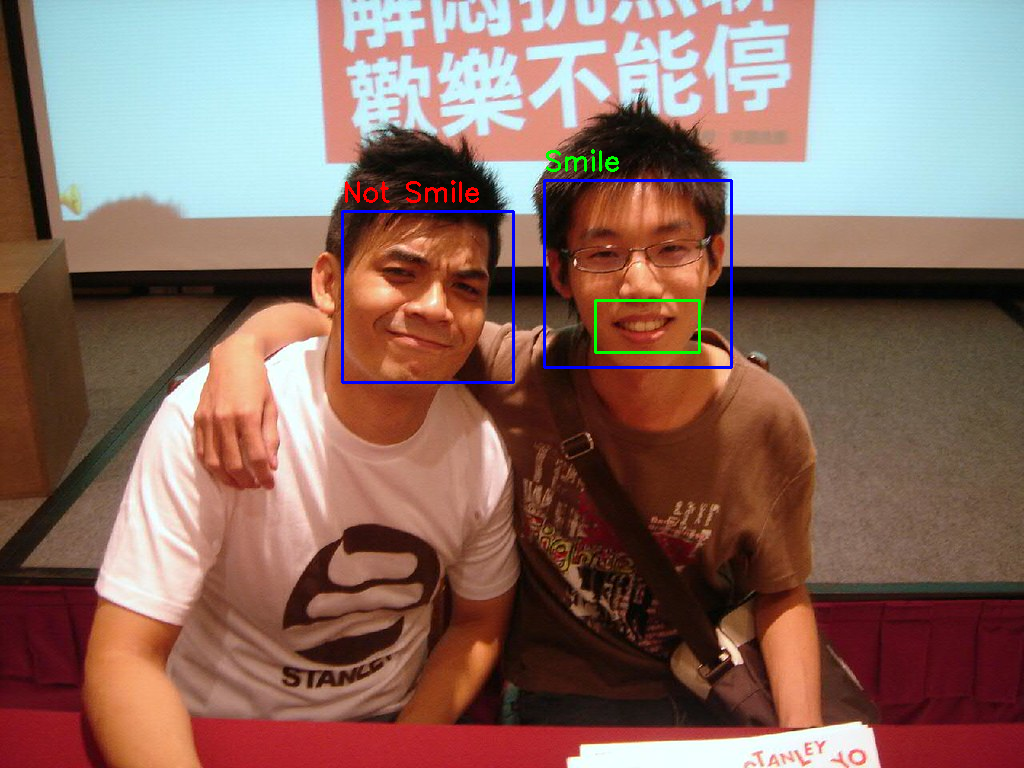

In [2]:
# 第一部分之2 -- 找到笑臉
# 匯入 OpenCV 與其他必要模組
import cv2
from google.colab.patches import cv2_imshow

# Load the Haar cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')


#標記臉與笑臉位置的函數
def detect_smile(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        smiles = smile_cascade.detectMultiScale(roi_gray, scaleFactor=1.7, minNeighbors=22, minSize=(25, 25))
        # Check if a smile is detected
        if len(smiles) > 0:
            # Smile detected
            cv2.putText(img, 'Smile', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            for (sx, sy, sw, sh) in smiles:
                cv2.rectangle(roi_color, (sx, sy), (sx + sw, sy + sh), (0, 255, 0), 2)
        else:
            # No smile detected
            cv2.putText(img, 'Not Smile', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    return img

#上傳測試影像後，自行修改檔名使用
img = cv2.imread("b.jpg")
cv2_imshow(detect_smile(img))



In [3]:
# 第二部分找出是誰的臉

# 匯入 OpenCV 與其他必要模組
import cv2
import numpy as np
import os
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 設定顯示中文（如需要）
#plt.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['axes.unicode_minus'] = False

# 定義一個函數，用來讀取資料夾內所有圖片，並利用指定的 cascade 偵測人臉
def load_faces_from_folder(folder_path, cascade):
    faces = []
    ids = []
    file_list = os.listdir(folder_path)
    file_list.sort()  # 保持順序
    for file_name in file_list:
        img_path = os.path.join(folder_path, file_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 偵測人臉
        detected = cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        for (x, y, w, h) in detected:
            face_roi = gray[y:y+h, x:x+w]
            faces.append(face_roi)
            # 根據資料夾命名或其他規則來設定 id，這裡假設資料夾名稱就是 id 標示
            # 例如：資料夾 "face01" 代表 id = 1, "face02" 代表 id = 2
            folder_id = int(folder_path[-2:])  # 依照資料夾最後兩個字元轉 int（請依實際情況調整）
            ids.append(folder_id)
    return faces, ids


In [4]:
# 方法一：使用預設 frontalface_default
cascade_default = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# 方法二：使用 alternate 權重檔（請確認此 xml 存在於 xml 資料夾中）
cascade_alt = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

# 請先上傳兩個xml檔
# 檢查是否載入成功
if cascade_default.empty():
    print("無法載入 haarcascade_frontalface_default.xml")
if cascade_alt.empty():
    print("無法載入 haarcascade_frontalface_alt2.xml")


default cascade 偵測到 33 張人臉
alternate cascade 偵測到 24 張人臉


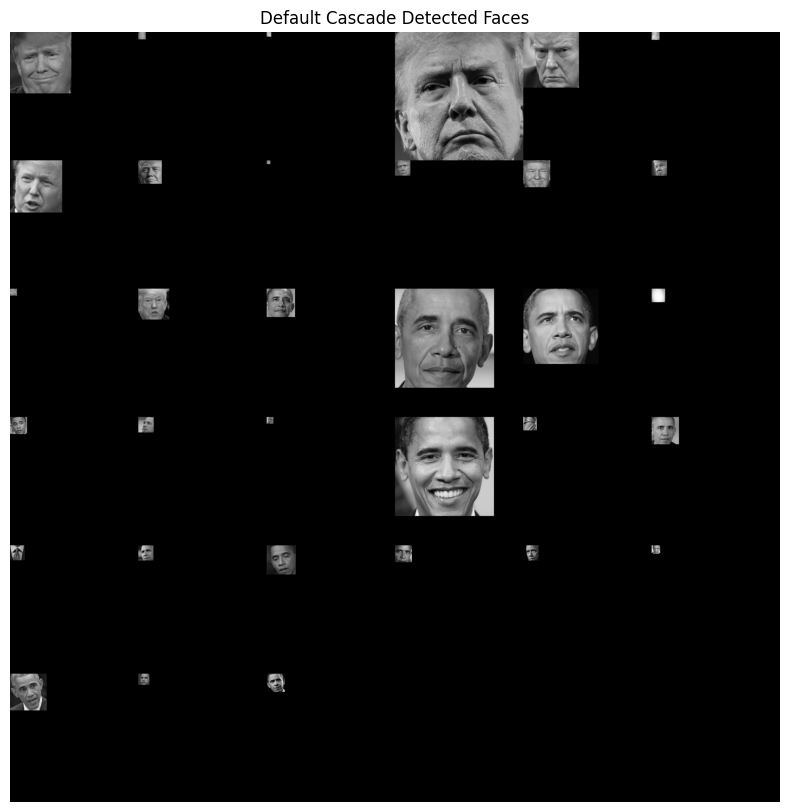

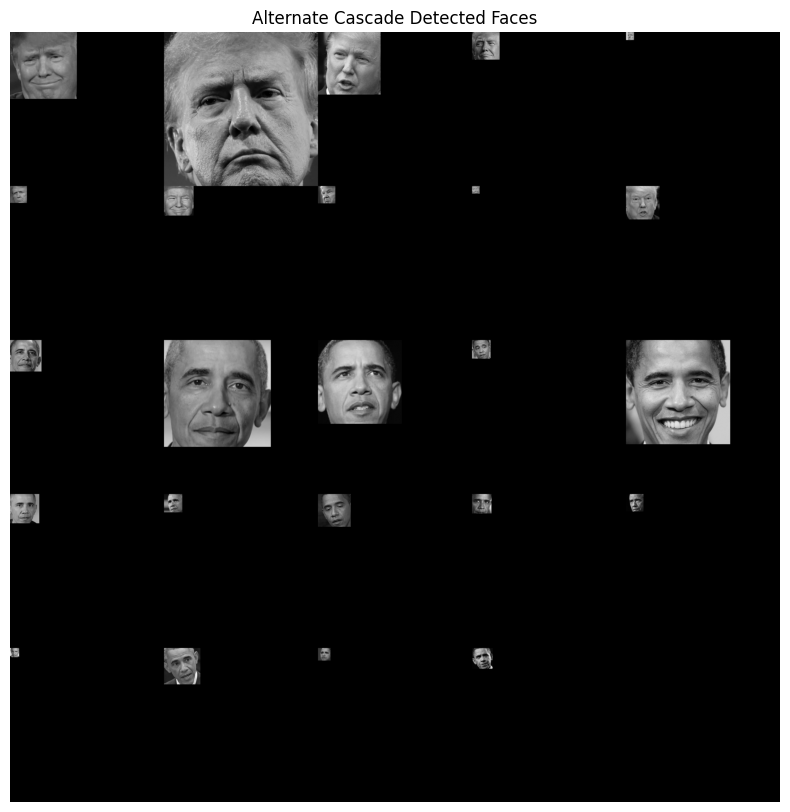

In [5]:
# 載入 face01 使用預設 cascade 模型
faces_default, ids_default = load_faces_from_folder('face01', cascade_default)
# 載入 face02 使用預設 cascade 模型
faces_default2, ids_default2 = load_faces_from_folder('face02', cascade_default)

# 合併兩組資料
faces_all_default = faces_default + faces_default2
ids_all_default = ids_default + ids_default2

# 同理，利用 alternate cascade 來取得一組人臉資料
faces_alt, ids_alt = load_faces_from_folder('face01', cascade_alt)
faces_alt2, ids_alt2 = load_faces_from_folder('face02', cascade_alt)

faces_all_alt = faces_alt + faces_alt2
ids_all_alt = ids_alt + ids_alt2

print(f"default cascade 偵測到 {len(faces_all_default)} 張人臉")
print(f"alternate cascade 偵測到 {len(faces_all_alt)} 張人臉")

# 將找到的人臉分組合併成一張圖片
def combine_faces(faces):
    # 計算圖片大小
    num_faces = len(faces)
    if num_faces == 0:
        return None

    rows = int(np.ceil(np.sqrt(num_faces)))
    cols = int(np.ceil(num_faces / rows))

    # 建立空白圖片
    max_height = max(face.shape[0] for face in faces)
    max_width = max(face.shape[1] for face in faces)
    combined_image = np.zeros((rows * max_height, cols * max_width), dtype=np.uint8)

    # 將人臉貼到空白圖片上
    current_row = 0
    current_col = 0
    for face in faces:
        h, w = face.shape
        combined_image[current_row * max_height:(current_row + 1) * max_height,
                       current_col * max_width:(current_col + 1) * max_width][:h, :w] = face

        current_col += 1
        if current_col == cols:
            current_col = 0
            current_row += 1

    return combined_image

# 合併 default cascade 找到的人臉
combined_default = combine_faces(faces_all_default)
# 合併 alternate cascade 找到的人臉
combined_alt = combine_faces(faces_all_alt)

# 顯示合併後的圖片
if combined_default is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(combined_default, cmap='gray')
    plt.title('Default Cascade Detected Faces')
    plt.axis('off')
    plt.show()

if combined_alt is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(combined_alt, cmap='gray')
    plt.title('Alternate Cascade Detected Faces')
    plt.axis('off')
    plt.show()


In [6]:
# 建立 LBPHFaceRecognizer 模型 (注意：cv2.face 模組可能需要 opencv-contrib-python)
recognizer_default = cv2.face.LBPHFaceRecognizer_create()
print(f'使用{len(faces_all_default)}張臉 開始訓練 LBPH 模型 (預設 cascade)...')
recognizer_default.train(faces_all_default, np.array(ids_all_default))
recognizer_default.save('face_default.yml')
print('訓練完成並儲存 face_default.yml')


使用33張臉 開始訓練 LBPH 模型 (預設 cascade)...
訓練完成並儲存 face_default.yml


In [7]:
#同理，可以使用 alternate cascade 偵測的資料來訓練另一個模型以作比較。
recognizer_alt = cv2.face.LBPHFaceRecognizer_create()
print(f'使用{len(faces_all_alt)}張臉 開始訓練 LBPH 模型 (alternate cascade)...')
recognizer_alt.train(faces_all_alt, np.array(ids_all_alt))
recognizer_alt.save('face_alt.yml')
print('訓練完成並儲存 face_alt.yml')


使用24張臉 開始訓練 LBPH 模型 (alternate cascade)...
訓練完成並儲存 face_alt.yml


下段程式碼分別使用兩個不同的 CascadeClassifier 進行人臉偵測，再利用對應 LBPH 模型進行辨識。  
信心指數 (confidence) 越低代表辨識越有把握；我們設定低於 60 為辨識成功。  
可透過上傳相同測試圖片，觀察兩種方法在偵測到的人臉數量與辨識結果（例如信心指數、標籤是否正確）上的差異，以便討論哪一種方法在該情境下較為穩定或準確。

辨識結果 - 預設 Cascade


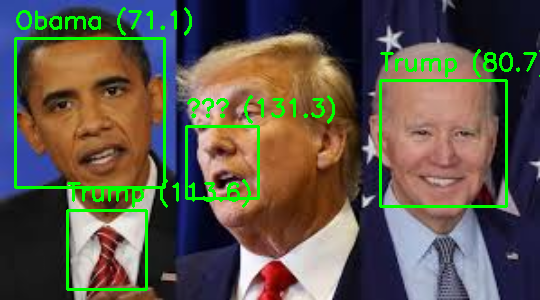

辨識結果 - Alternate Cascade


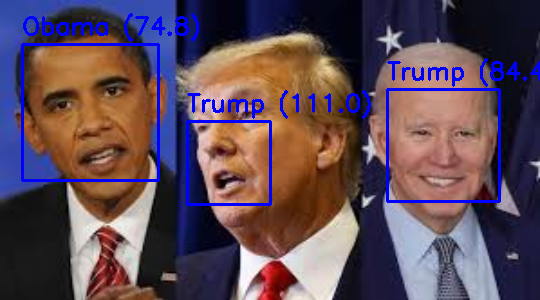

In [8]:
from google.colab.patches import cv2_imshow

# 設定測試圖片路徑 (可使用自己上傳的測試圖片)
test_img_path = 'test.jpg'  # 測試圖片需自行上傳
img = cv2.imread(test_img_path)
if img is None:
    print("請上傳測試圖片 test.jpg")
else:
    img_resized = cv2.resize(img, (540, 300))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # 用預設 cascade 偵測
    faces_detected_default = cascade_default.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    # 用 alternate cascade 偵測
    faces_detected_alt = cascade_alt.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    # 定義一個簡單的名稱對照表（假設 id 1 為 Trump, 2 為 Obama)
    names = {1: 'Trump', 2: 'Obama'}

    # 複製原圖用於標示
    img_out_default = img_resized.copy()
    img_out_alt = img_resized.copy()

    # 使用預設 cascade 與相應 LBPH 模型辨識
    for (x, y, w, h) in faces_detected_default:
        face_roi = gray[y:y+h, x:x+w]
        idnum, confidence = recognizer_default.predict(face_roi)
        label = names.get(idnum, '???') if confidence < 120 else '???'
        cv2.rectangle(img_out_default, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img_out_default, f"{label} ({confidence:.1f})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    # 使用 alternate cascade 與相應 LBPH 模型辨識
    for (x, y, w, h) in faces_detected_alt:
        face_roi = gray[y:y+h, x:x+w]
        idnum, confidence = recognizer_alt.predict(face_roi)
        label = names.get(idnum, '???') if confidence < 120 else '???'
        cv2.rectangle(img_out_alt, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img_out_alt, f"{label} ({confidence:.1f})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)

    # 顯示比較結果
    print("辨識結果 - 預設 Cascade")
    cv2_imshow(img_out_default)
    print("辨識結果 - Alternate Cascade")
    cv2_imshow(img_out_alt)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [9]:
# 假設我們有一組測試圖片路徑及對應的 ground truth id
test_images = ['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg']  # 請自行準備測試圖片
ground_truth = [2, 2, 1, 1]  # 與圖片對應的正確 id

predictions_default = []
predictions_alt = []

for idx, img_path in enumerate(test_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.resize(img, (540, 300))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 以預設 cascade 偵測並辨識 (取第一個偵測到的人臉)
    faces = cascade_default.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face_roi = gray[y:y+h, x:x+w]
        idnum, confidence = recognizer_default.predict(face_roi)
        predictions_default.append(idnum)
    else:
        predictions_default.append(-1)

    # 以 alternate cascade 偵測並辨識
    faces = cascade_alt.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face_roi = gray[y:y+h, x:x+w]
        idnum, confidence = recognizer_alt.predict(face_roi)
        predictions_alt.append(idnum)
    else:
        predictions_alt.append(-1)

# 計算準確率
acc_default = accuracy_score(ground_truth, predictions_default)
acc_alt = accuracy_score(ground_truth, predictions_alt)

print(f"使用預設 Cascade 的辨識準確率: {acc_default*100:.2f}%")
print(f"使用 alternate Cascade 的辨識準確率: {acc_alt*100:.2f}%")


使用預設 Cascade 的辨識準確率: 50.00%
使用 alternate Cascade 的辨識準確率: 50.00%


#演算法原理說明與重點  
**Haar Cascade 原理說明 **  
Haar 特徵：利用簡單矩形特徵（例如邊緣、線條、中心對比）來表示圖像特徵。  
積分影像：加速計算矩形區域內的像素總和，使得特徵計算高效。  
AdaBoost 與級聯分類器：利用 AdaBoost 組合多個弱分類器，並以級聯方式快速排除不符合條件的區域，達到即時偵測的效果。  
比較：預設的 "haarcascade_frontalface_default.xml" 與 "haarcascade_frontalface_alt.xml" 在不同場景下的偵測效果會有所差異，可透過本範例進行實驗比較。  
**LBPH Face Recognizer 原理說明 **  
局部二值模式 (LBP)：將每個像素與周圍鄰居比較，產生二進位碼，描述局部紋理特徵。
直方圖統計：將整張人臉圖切分成數個區域，統計各區域內的 LBP 分布，再將直方圖串接起來作為特徵向量。  
距離度量：在辨識時，將待測人臉的 LBPH 特徵向量與已訓練資料進行距離比較，最小距離即為匹配結果。  

其他參考資料:  
https://shichaoxin.com/2023/10/16/OpenCV%E5%9F%BA%E7%A1%80-%E7%AC%AC%E5%9B%9B%E5%8D%81%E4%B8%80%E8%AF%BE-LBP%E7%89%B9%E5%BE%81/  
https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/  
https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html

